### Customer Segmentation - PCA and Kmeans ###

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
order_products_train_df = pd.read_csv("./data/order_products__train.csv")
order_products_prior_df = pd.read_csv("./data/order_products__prior.csv")
orders_df = pd.read_csv("./data/orders.csv")
products_df = pd.read_csv("./data/products.csv")
aisles_df = pd.read_csv("./data/aisles.csv")
departments_df = pd.read_csv("./data/departments.csv")

In [3]:
order_products_prior_df = pd.merge(order_products_prior_df,products_df,on='product_id',how='left')
order_products_prior_df = pd.merge(order_products_prior_df,aisles_df,on='aisle_id',how='left')
order_products_prior_df = pd.merge(order_products_prior_df,departments_df,on='department_id',how='left')
order_products_prior_df = pd.merge(order_products_prior_df,orders_df,on='order_id',how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [4]:
print("# Unique products = ",order_products_prior_df.product_name.nunique())
print("# Unique aisles = ",order_products_prior_df.aisle.nunique())
print("# Unique departments = ",order_products_prior_df.department.nunique())

# Unique products =  49677
# Unique aisles =  134
# Unique departments =  21


In [5]:
# Adding some user level metrics to aid segmentation
user_order_freq = order_products_prior_df.groupby(['user_id'], as_index=False)['days_since_prior_order'].mean().rename(columns={'days_since_prior_order':'freq'})
user_order_freq.freq = user_order_freq.freq.astype(int)

In [6]:
# Creating a dataframe with all the purchases made by each user - by Aisle
cust_aisle = pd.crosstab(order_products_prior_df.user_id, order_products_prior_df.aisle)
cust_aisle.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(cust_aisle)
pca_samples = pca.transform(cust_aisle)
pca.explained_variance_ratio_

array([0.48237998, 0.09585824, 0.05185877, 0.03590181, 0.0293466 ,
       0.02393094])

In [8]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5
0,-24.215659,2.429427,-2.466369,-0.145698,0.269042,-1.432836
1,6.463208,36.751116,8.382553,15.097531,-6.920941,-0.978341
2,-7.990302,2.404383,-11.030064,0.672226,-0.442371,-2.823008
3,-27.991129,-0.755823,-1.921732,2.091888,-0.288232,0.926171
4,-19.896394,-2.637225,0.533229,3.679228,0.612826,-1.623968


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


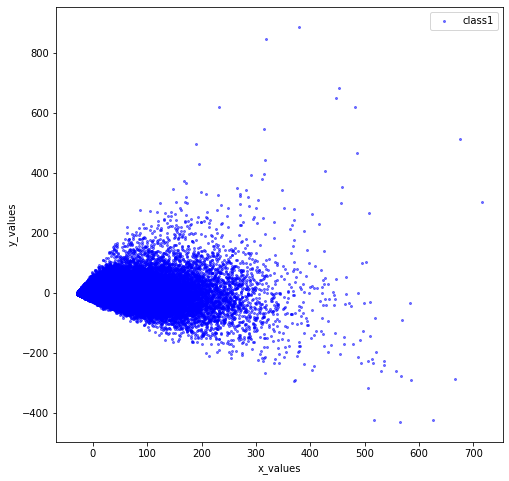

In [9]:
fig = plt.figure(figsize=(8,8))
plt.plot(ps[0],ps[1], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [10]:
tocluster = pd.DataFrame(ps)

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[-1.63607335e+01 -2.50428582e-01 -1.48670675e-01  3.82248954e-01
   1.21999192e-02  1.20389098e-01]
 [ 4.76723691e+01  1.71806125e+00  1.23230213e+00 -2.76954576e+00
  -2.81621996e-01 -9.39445785e-01]
 [ 1.78043275e+02 -1.91515956e+00 -2.13396129e+00  3.61406126e+00
   1.02257214e+00  1.45365706e+00]]


In [21]:
clust_prod = cust_aisle.copy()
clust_prod['cluster'] = c_preds

clust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,3,0,0,0,0,2,0,0,0,...,1,1,0,0,0,0,2,0,42,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,5,0
8,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,6,0,2,0,0,0,...,0,0,0,0,0,0,2,0,19,0


In [22]:
c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
c4 = clust_prod[clust_prod['cluster']==4].drop('cluster',axis=1).mean()

In [32]:
c2.sort_values(ascending=False)[0:20]

aisle
fresh fruits                     130.994871
fresh vegetables                 123.522567
packaged vegetables fruits        56.624853
yogurt                            46.011870
packaged cheese                   27.333968
milk                              26.262309
soy lactosefree                   17.209115
baby food formula                 16.166032
chips pretzels                    15.904601
bread                             15.899766
water seltzer sparkling water     15.745750
frozen produce                    14.080305
refrigerated                      13.786635
fresh herbs                       13.456624
energy granola bars               12.248242
eggs                              11.269197
crackers                          11.186401
lunch meat                        10.465416
fresh dips tapenades               9.364742
ice cream ice                      8.835727
dtype: float64

In [19]:
#Looking at the top 10 aisles for the 5 clusters - saved .txt
c4.sort_values(ascending=False)[0:10]

aisle
air fresheners candles   NaN
asian foods              NaN
baby accessories         NaN
baby bath body care      NaN
baby food formula        NaN
bakery desserts          NaN
baking ingredients       NaN
baking supplies decor    NaN
beauty                   NaN
beers coolers            NaN
dtype: float64

In [27]:
# evaluating the number of clusters that seem appropriate
Ks = range(1, 10)
km = [KMeans(n_clusters=i,random_state=42) for i in Ks]
score = [km[i].fit(tocluster).score(tocluster) for i in range(len(km))]

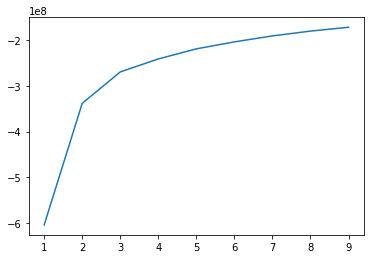

In [31]:
import matplotlib.pyplot as plt
plt.plot(Ks,score)